In [1]:
import os

from utils import load_jsonl_iteratively

result_root = "/data/xzhao/experiments/med-eval/dataset/losses/results/random_2k/"
model_name = "exp1-multi-ja"
lang = "ja"

def collect_loss_data(sequence_type, distortion):
    """Collect loss data for a given sequence_type and distortion"""
    result_dir = os.path.join(result_root, f"{lang}_{sequence_type}_{distortion}", f"llm-jp-3-13b-{model_name}")
    
    iterations = []
    avg_losses = []
    noisy_rates = []
    for filename in sorted(os.listdir(result_dir)):
        iteration = int(filename[5:-6])
        if 0 < iteration < 500:
            continue
        
        avg_loss = 0
        filepath = os.path.join(result_dir, filename)
        
        cnt = 0
        noisy_token_cnt, all_token_cnt = 0, 0
        for item in load_jsonl_iteratively(filepath):
            avg_loss += item['avg_loss']
            noisy_token_cnt += sum(1 for label in item['metadata']['token_labels'] if label != '<token>')
            all_token_cnt += len(item['metadata']['token_labels'])
            cnt += 1
        
        iterations.append(iteration)
        avg_losses.append(avg_loss / cnt if cnt > 0 else -1)
        noisy_rates.append(noisy_token_cnt / all_token_cnt)
    if len(avg_losses) > 0:
        assert len(set(noisy_rates)) == 1, "Noisy rates should be the same for all iterations, but got {}".format(noisy_rates)
    return iterations, avg_losses, noisy_rates[0]

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams

# Configure matplotlib for LaTeX-style rendering
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['text.usetex'] = True
rcParams['figure.dpi'] = 300

# Define a fixed color palette and mapping for sequence types and distortions
COLOR_PALETTE = sns.color_palette("Set2", 10)  # Use Set2 with 10 colors for consistency

def plot_multiple_loss_curves_by_sequence(sequence_types, title=None, noisy_rate=None, show_noise_rate=False):
    """Plot multiple loss curves with sequence_type as parameters for academic publication (smaller size)"""
    
    # Create smaller figure
    fig, ax = plt.subplots(figsize=(4.5, 2.3))
    
    for i, sequence_type in enumerate(sequence_types):
        try:
            iterations, avg_losses, _noisy_rate = collect_loss_data(sequence_type, "original")
            _noisy_rate = noisy_rate if noisy_rate is not None else _noisy_rate
            label = f'{sequence_type} ({_noisy_rate:.0%})' if show_noise_rate else f'{sequence_type}'
            
            # Use color from COLOR_MAPPING, default to a fallback if not found
            color = COLOR_PALETTE[i]
            
            # Plot main curve with shaded area
            ax.plot(iterations, avg_losses,
                    label=label,
                    color=color,
                    linewidth=2,
                    alpha=0.9)
            ax.fill_between(iterations, avg_losses, alpha=0.1, color=color)
            
            # Mark minimum point
            min_idx = np.argmin(avg_losses)
            min_x = iterations[min_idx]
            min_y = avg_losses[min_idx]
            ax.scatter([min_x], [min_y], 
                      marker='^', 
                      s=80, 
                      color=color, 
                      zorder=5)
            
            # Add annotation for minimum point
            ax.annotate(f'{min_y:.3f}', 
                       xy=(min_x, min_y), 
                       xytext=(4, 4),
                       textcoords='offset points',
                       fontsize=7,
                       color=color)
            
            print(f"✓ Plotted {sequence_type}: {len(iterations)} data points")
        
        except Exception as e:
            print(f"⚠️  Error plotting {sequence_type}: {str(e)}")
            continue
    
    # Customize axes with smaller fonts
    ax.set_xlabel(r'\textbf{Iteration}', fontsize=10)
    ax.set_ylabel(r'\textbf{Average Loss}', fontsize=10)
    
    # Customize grid and spines
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Customize legend
    ax.legend(bbox_to_anchor=(1.05, 1), 
              loc='upper left',
              frameon=True,
              fontsize=8,
              framealpha=0.95,
              edgecolor='gray')
    
    plt.tight_layout()
    return fig

def plot_multiple_loss_curves_by_distortion(distortions, title=None, noisy_rate=None, show_noise_rate=False):
    """Plot multiple loss curves with distortion as parameters for academic publication (smaller size)"""
    
    # Create smaller figure
    fig, ax = plt.subplots(figsize=(4.5, 2.3))
    
    for i, distortion in enumerate(distortions):
        try:
            iterations, avg_losses, _noisy_rate = collect_loss_data("full", distortion)
            _noisy_rate = noisy_rate if noisy_rate is not None else _noisy_rate
            label = f'{distortion}'
            
            if label.startswith("retoken-"):
                label = label.replace("retoken-", "reorder-")
            elif label.startswith("replace-"):
                label = label.replace("replace-", "random-")
            elif label.startswith("monosyn-"):
                if noisy_rate is not None:
                    label = "monosyn-" + str(int(noisy_rate*100))
            elif label.startswith("mltlsyn-"):
                if noisy_rate is not None:
                    label = "mltlsyn-" + str(int(noisy_rate*100))
            elif label.startswith("rewrite@"):
                label = label.replace("rewrite@", "")
            
            # Use color from COLOR_MAPPING, default to a fallback if not found
            color = COLOR_PALETTE[i]
            
            # Plot main curve with shaded area
            ax.plot(iterations, avg_losses,
                    label=label,
                    color=color,
                    linewidth=2,
                    alpha=0.9)
            ax.fill_between(iterations, avg_losses, alpha=0.1, color=color)
            
            # Mark minimum point
            min_idx = np.argmin(avg_losses)
            min_x = iterations[min_idx]
            min_y = avg_losses[min_idx]
            ax.scatter([min_x], [min_y], 
                      marker='^', 
                      s=80, 
                      color=color, 
                      zorder=5)
            
            # Add annotation for minimum point
            ax.annotate(f'{min_y:.3f}', 
                       xy=(min_x, min_y), 
                       xytext=(4, 4),
                       textcoords='offset points',
                       fontsize=7,
                       color=color)
            
            print(f"✓ Plotted {distortion}: {len(iterations)} data points")
        
        except Exception as e:
            print(f"⚠️  Error plotting {distortion}: {str(e)}")
            # continue
            raise e
    
    # Customize axes with smaller fonts
    ax.set_xlabel(r'\textbf{Iteration}', fontsize=10)
    ax.set_ylabel(r'\textbf{Average Loss}', fontsize=10)
    
    # Customize grid and spines
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Customize legend
    ax.legend(bbox_to_anchor=(1.05, 1), 
              loc='upper left',
              frameon=True,
              fontsize=8,
              framealpha=0.95,
              edgecolor='gray')
    
    plt.tight_layout()
    return fig

✓ Plotted full: 18 data points
✓ Plotted partial-1: 18 data points
✓ Plotted partial-2: 18 data points
✓ Plotted partial-3: 18 data points
✓ Plotted partial-4: 18 data points


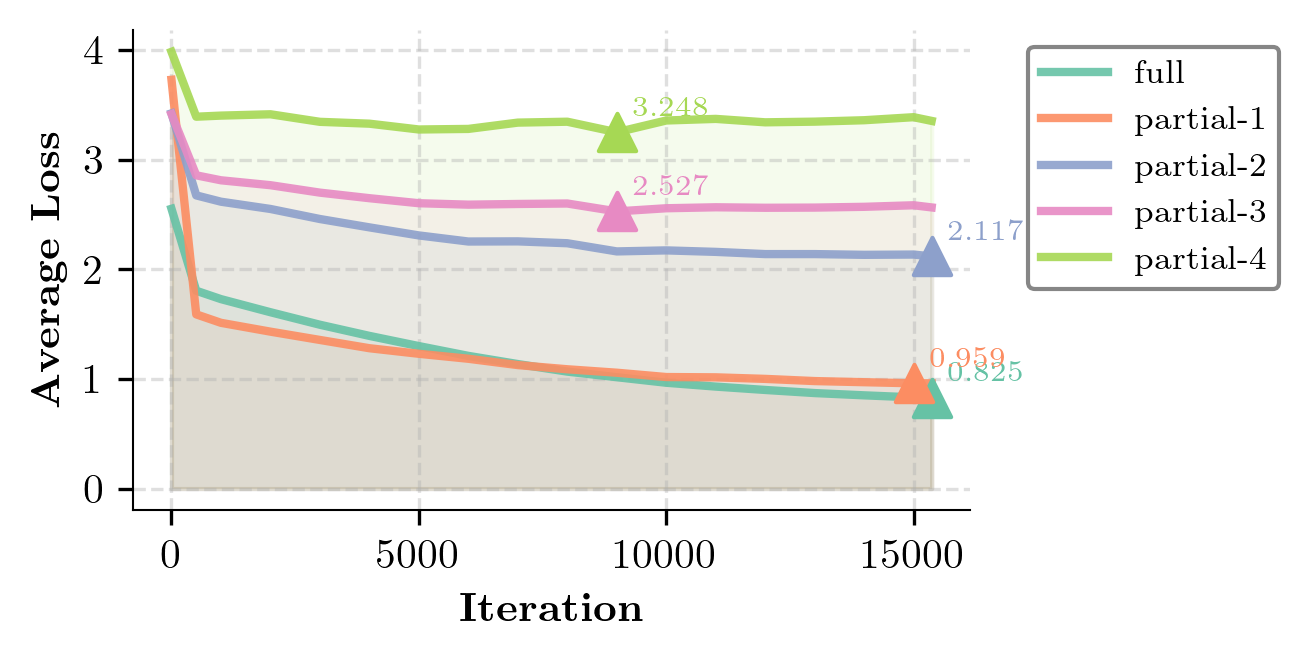

In [3]:
sequence_types = ["full", "partial-1", "partial-2", "partial-3", "partial-4"]
fig = plot_multiple_loss_curves_by_sequence(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-partial-a.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)    

✓ Plotted full: 18 data points
✓ Plotted partial-12: 18 data points
✓ Plotted partial-13: 18 data points
✓ Plotted partial-14: 18 data points
✓ Plotted partial-23: 18 data points
✓ Plotted partial-24: 18 data points
✓ Plotted partial-34: 18 data points


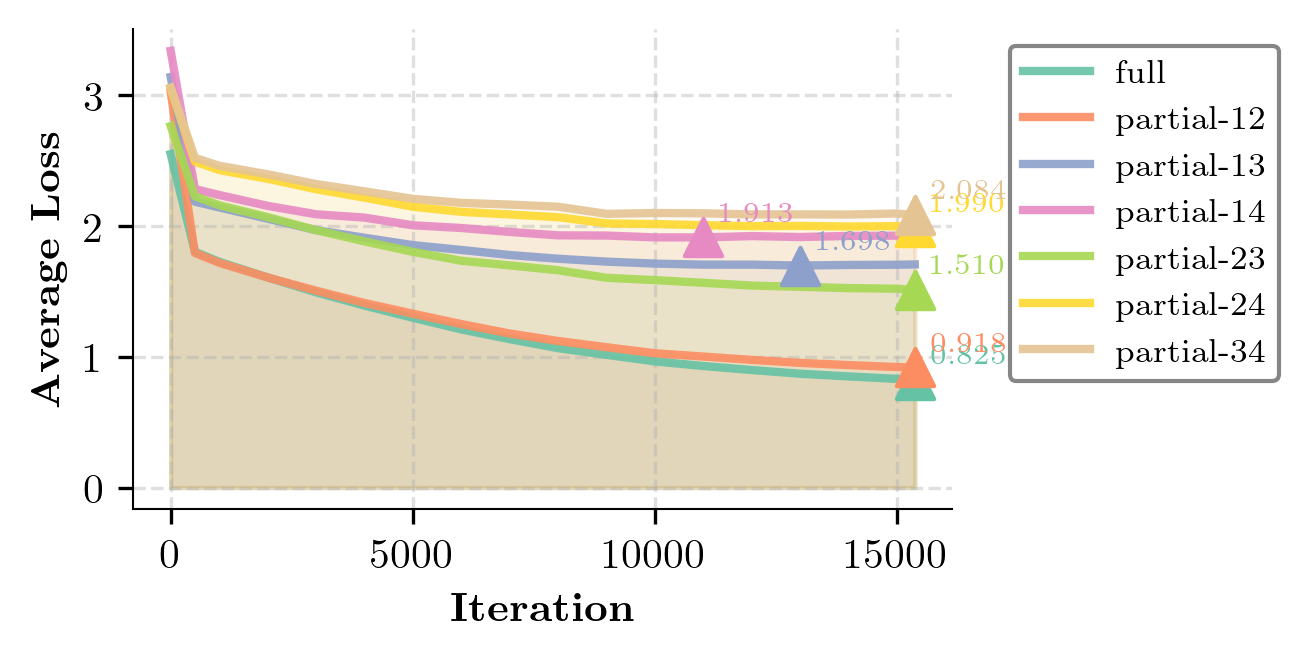

In [4]:
sequence_types = ["full", "partial-12", "partial-13", "partial-14", "partial-23", "partial-24", "partial-34"]
fig = plot_multiple_loss_curves_by_sequence(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-partial-ab.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)    

✓ Plotted original: 18 data points
✓ Plotted mask-2: 18 data points
✓ Plotted mask-4: 18 data points
✓ Plotted mask-8: 18 data points
✓ Plotted mask-16: 18 data points
✓ Plotted mask-32: 18 data points


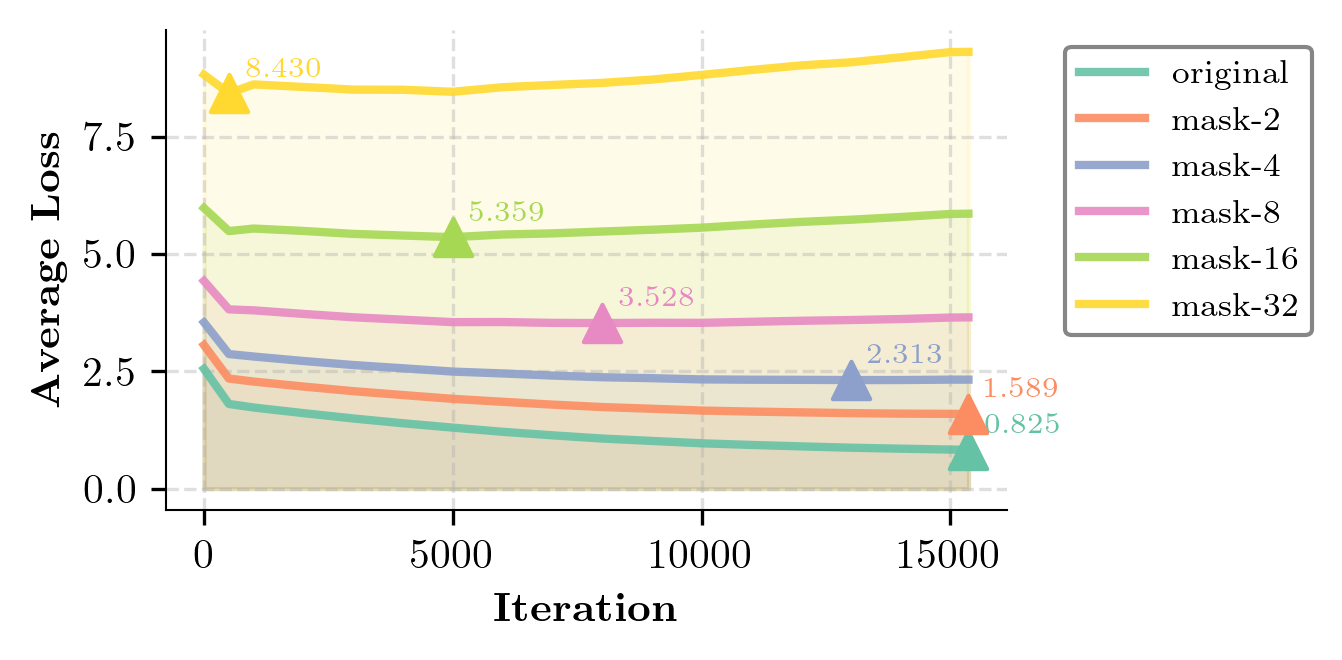

In [5]:
distortions = ["original", "mask-2", "mask-4", "mask-8", "mask-16", "mask-32"]
fig = plot_multiple_loss_curves_by_distortion(distortions, show_noise_rate=False)
fig.savefig('./loss_figures/ja-mask.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted delete-2: 18 data points
✓ Plotted delete-4: 18 data points
✓ Plotted delete-8: 18 data points
✓ Plotted delete-16: 18 data points
✓ Plotted delete-32: 18 data points


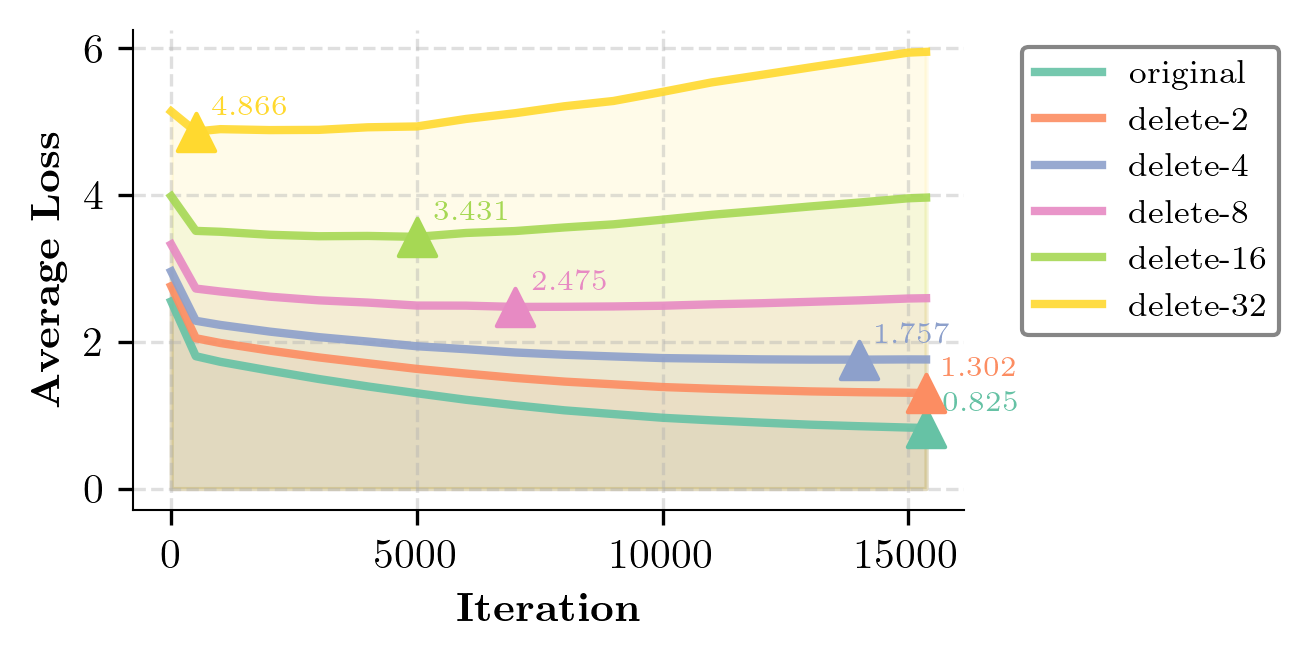

In [6]:
distortions = ["original", "delete-2", "delete-4", "delete-8", "delete-16", "delete-32"]
fig = plot_multiple_loss_curves_by_distortion(distortions, show_noise_rate=False)
fig.savefig('./loss_figures/ja-delete.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted replace-2: 18 data points
✓ Plotted replace-4: 18 data points
✓ Plotted replace-8: 18 data points
✓ Plotted replace-16: 18 data points
✓ Plotted replace-32: 18 data points


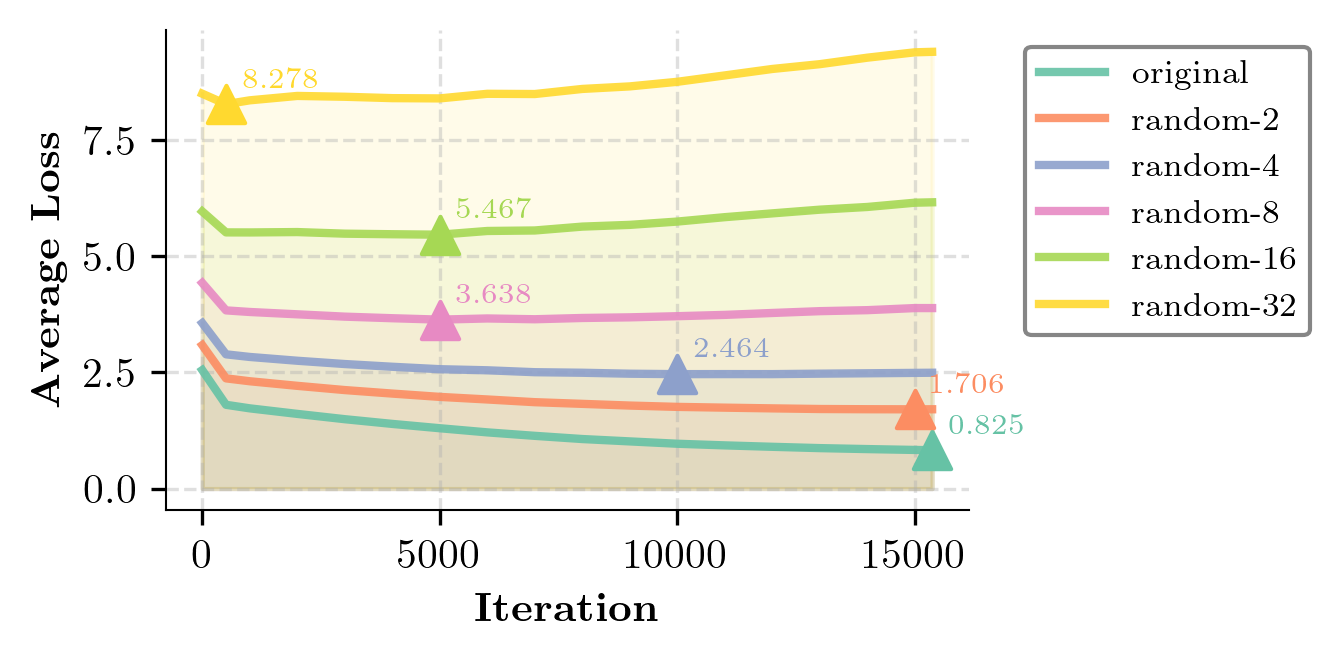

In [7]:
distortions = ["original", "replace-2", "replace-4", "replace-8", "replace-16", "replace-32"]
fig = plot_multiple_loss_curves_by_distortion(distortions)
fig.savefig('./loss_figures/ja-replace.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

In [8]:
# distortions = ["original", "resent-2", "resent-3", "resent-4"]
# fig = plot_multiple_loss_curves_by_distortion(distortions)
# fig.savefig('./loss_figures/ja-replace.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted retoken-2@3: 18 data points
✓ Plotted retoken-4@3: 18 data points
✓ Plotted retoken-8@3: 18 data points
✓ Plotted retoken-16@3: 18 data points
✓ Plotted retoken-32@3: 18 data points


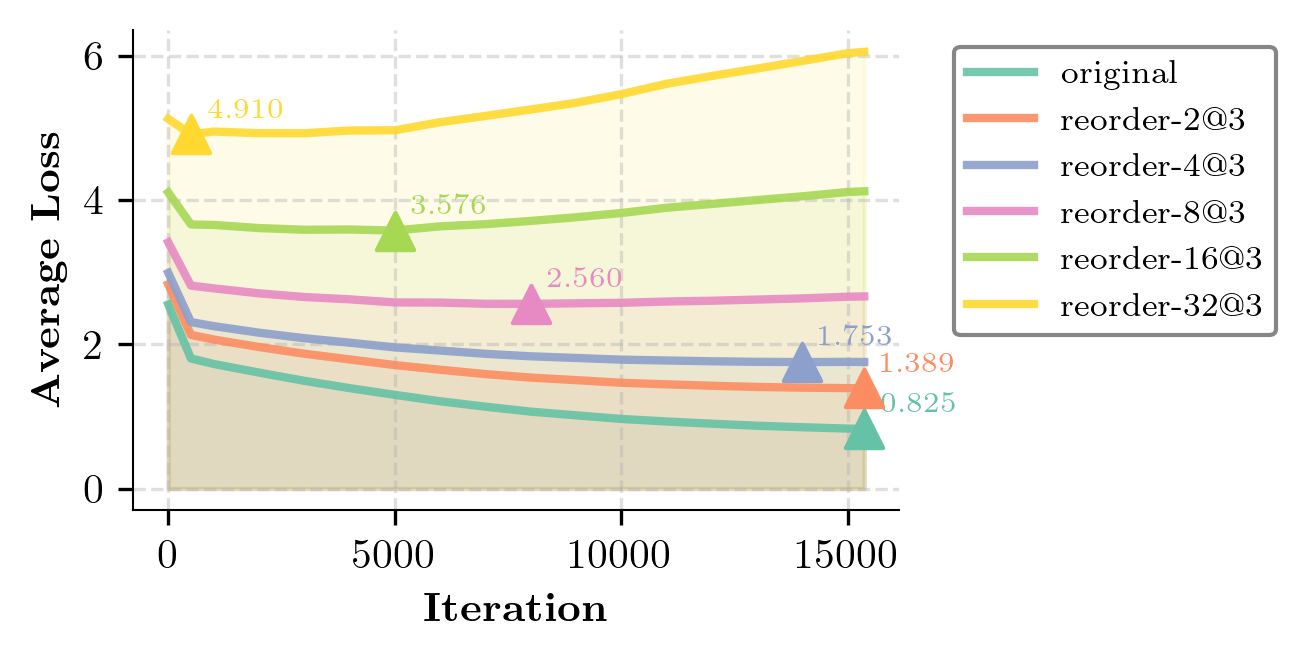

In [9]:
distortions = ["original", "retoken-2@3", "retoken-4@3", "retoken-8@3", "retoken-16@3", "retoken-32@3"]
fig = plot_multiple_loss_curves_by_distortion(distortions)
fig.savefig('./loss_figures/ja-reorder.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted retoken-4@1: 18 data points
✓ Plotted retoken-4@2: 18 data points
✓ Plotted retoken-4@4: 18 data points
✓ Plotted retoken-4@8: 18 data points
✓ Plotted retoken-4@16: 18 data points


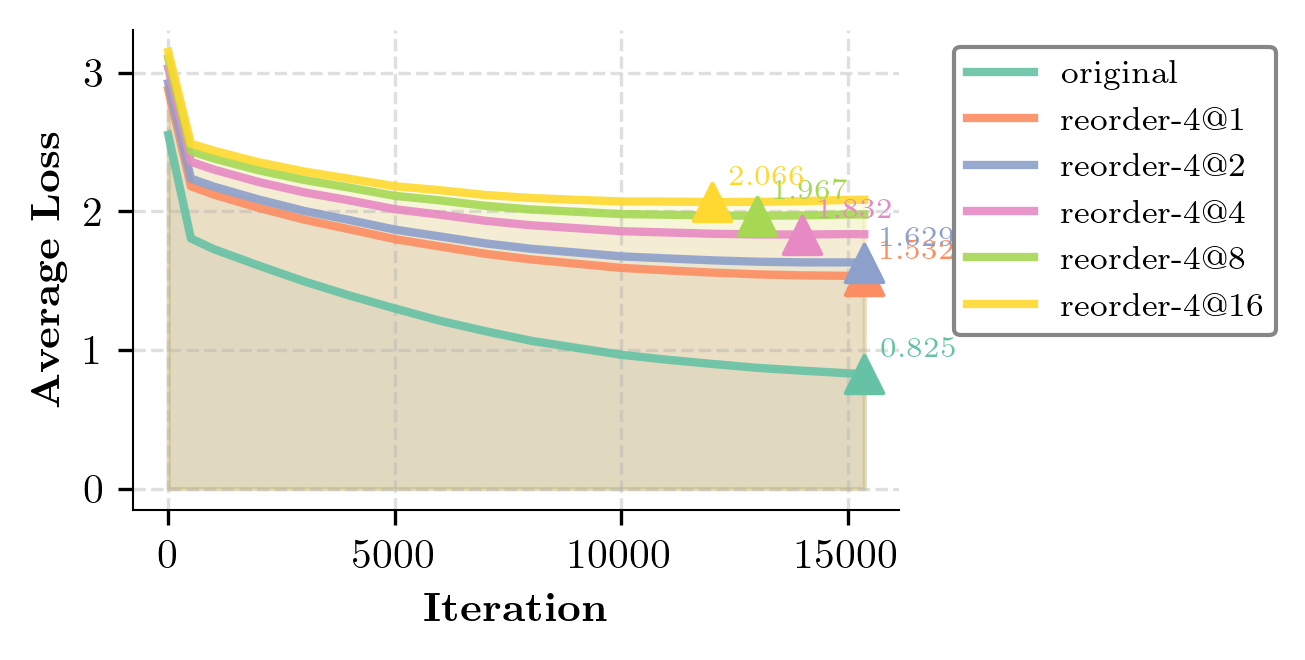

In [10]:
distortions = ["original", "retoken-4@1", "retoken-4@2", "retoken-4@4", "retoken-4@8", "retoken-4@16"]
fig = plot_multiple_loss_curves_by_distortion(distortions)
fig.savefig('./loss_figures/ja-reorder-windows.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted monosyn-8: 18 data points
✓ Plotted monosyn-16: 18 data points
✓ Plotted monosyn-32: 18 data points
✓ Plotted monosyn-64: 18 data points
✓ Plotted monosyn-100: 18 data points


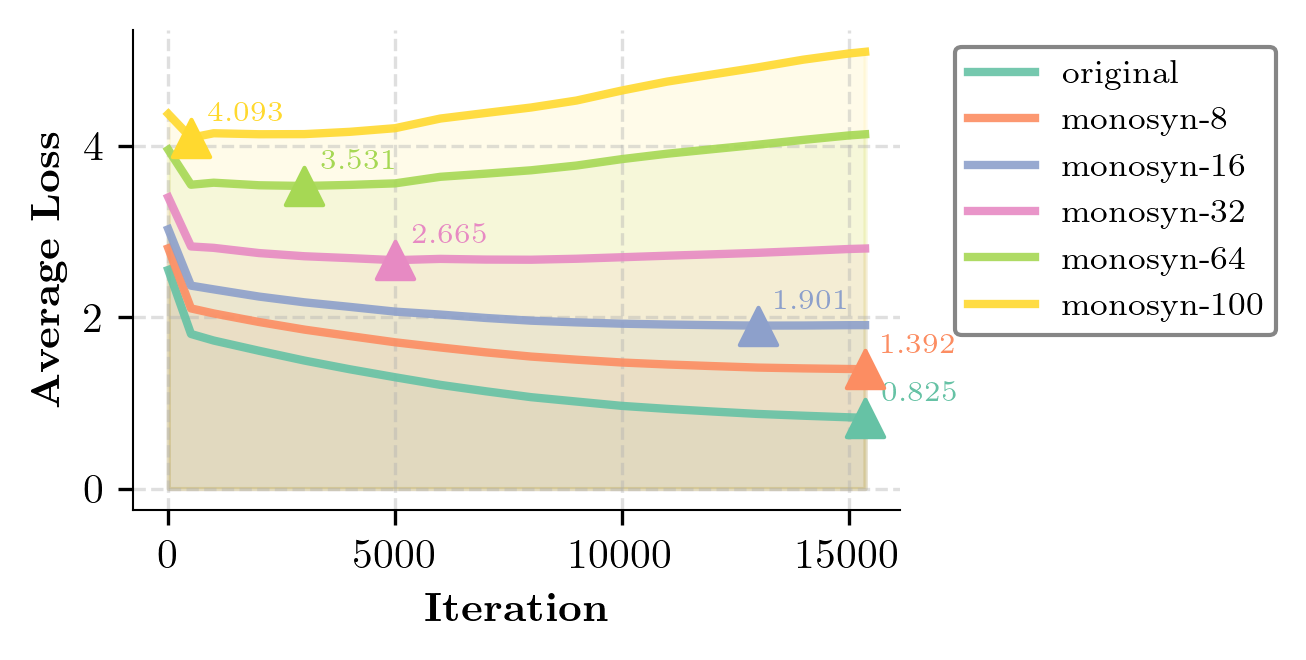

In [27]:
distortions = ["original", "monosyn-8", "monosyn-16", "monosyn-32", "monosyn-64", "monosyn-100"]
fig = plot_multiple_loss_curves_by_distortion(distortions, show_noise_rate=True)
fig.savefig('./loss_figures/ja-monosyn.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted mltlsyn-8: 18 data points
✓ Plotted mltlsyn-16: 18 data points
✓ Plotted mltlsyn-32: 18 data points
✓ Plotted mltlsyn-64: 18 data points
✓ Plotted mltlsyn-100: 18 data points


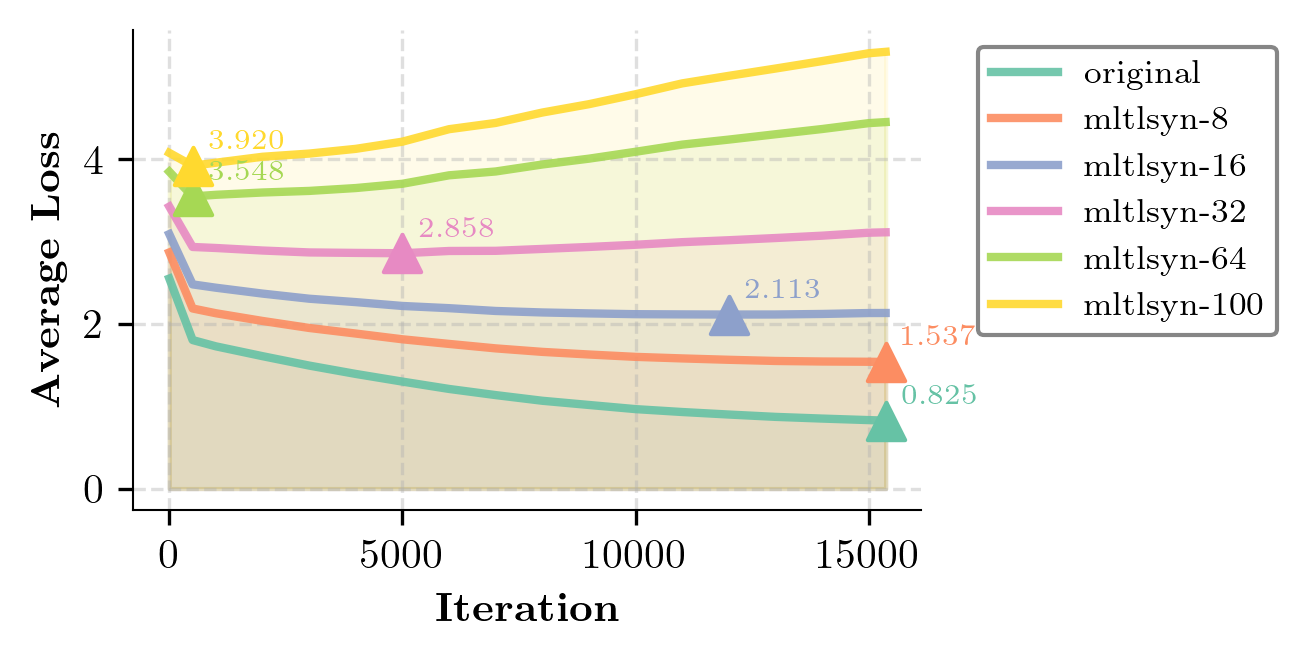

In [29]:
distortions = ["original", "mltlsyn-8", "mltlsyn-16", "mltlsyn-32", "mltlsyn-64", "mltlsyn-100"]
fig = plot_multiple_loss_curves_by_distortion(distortions, show_noise_rate=True)
fig.savefig('./loss_figures/ja-mltlsyn.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted mask-8: 18 data points
✓ Plotted delete-8: 18 data points
✓ Plotted replace-8: 18 data points
✓ Plotted retoken-8@3: 18 data points
✓ Plotted monosyn-21: 18 data points
✓ Plotted mltlsyn-16: 18 data points


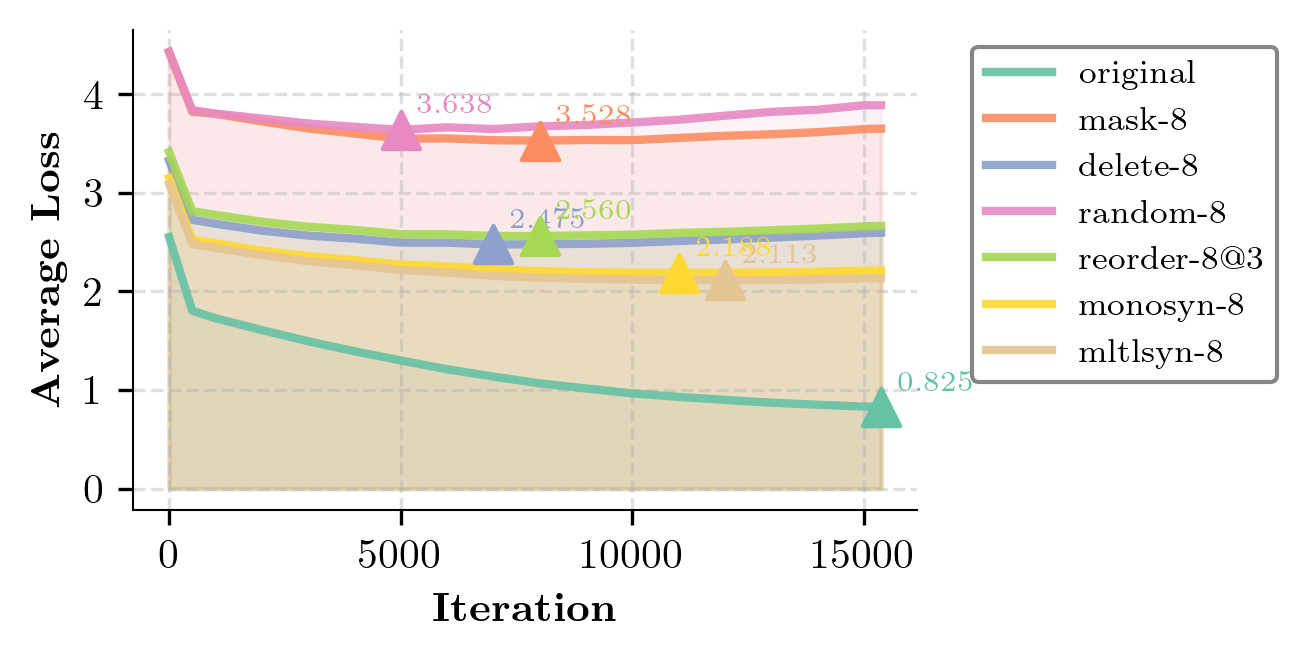

In [13]:
distortions = ["original", "mask-8", "delete-8", "replace-8", "retoken-8@3", "monosyn-21", "mltlsyn-16"]
fig = plot_multiple_loss_curves_by_distortion(distortions, title="Edit distance: 8%", noisy_rate=0.08, show_noise_rate=True)
fig.savefig('./loss_figures/ja-8-edit-distance.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted mask-16: 18 data points
✓ Plotted delete-16: 18 data points
✓ Plotted replace-16: 18 data points
✓ Plotted retoken-16@3: 18 data points
✓ Plotted monosyn-44: 18 data points
✓ Plotted mltlsyn-34: 18 data points


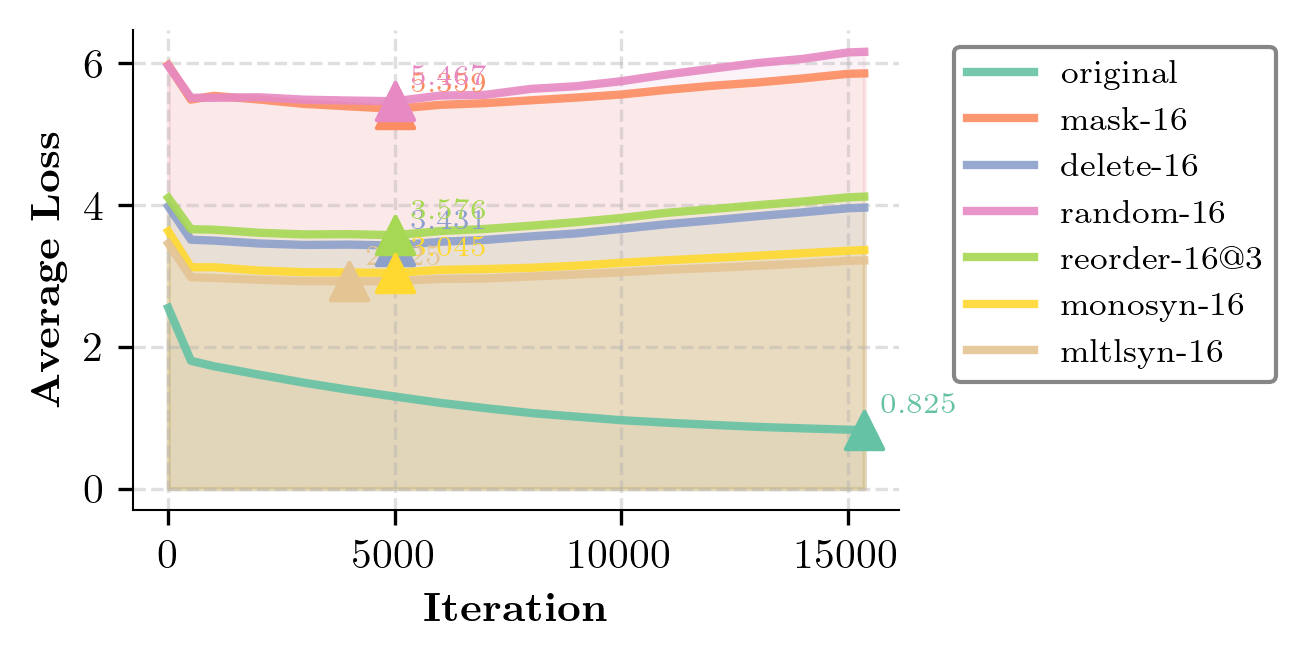

In [33]:
distortions = ["original", "mask-16", "delete-16", "replace-16", "retoken-16@3", "monosyn-44", "mltlsyn-34"]
fig = plot_multiple_loss_curves_by_distortion(distortions, title="Edit distance: 16%", noisy_rate=0.16, show_noise_rate=True)
fig.savefig('./loss_figures/ja-16-edit-distance.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted mask-32: 18 data points
✓ Plotted delete-32: 18 data points
✓ Plotted replace-32: 18 data points
✓ Plotted retoken-32@3: 18 data points
✓ Plotted monosyn-94: 18 data points
✓ Plotted mltlsyn-72: 18 data points


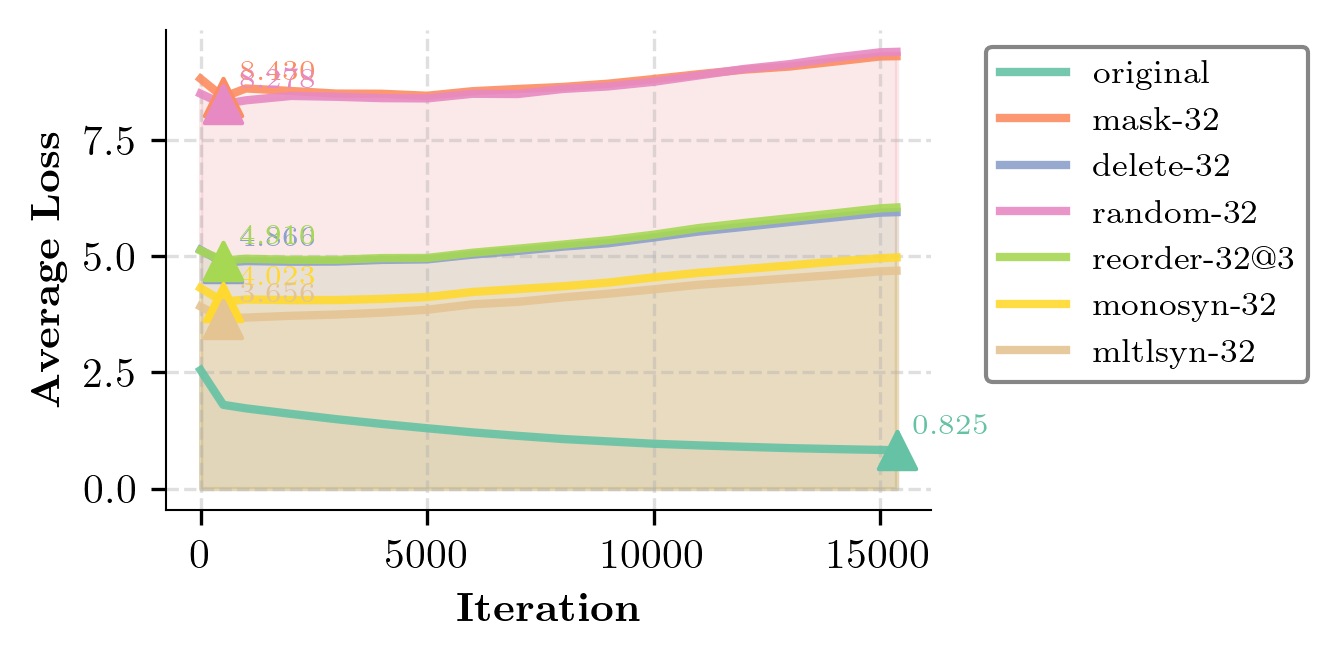

In [28]:
distortions = ["original", "mask-32", "delete-32", "replace-32", "retoken-32@3", "monosyn-94", "mltlsyn-72"]
fig = plot_multiple_loss_curves_by_distortion(distortions, title="Edit distance: 32%", noisy_rate=0.32, show_noise_rate=True)
fig.savefig('./loss_figures/ja-32-edit-distance.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted rewrite@syntax-20: 18 data points
✓ Plotted rewrite@syntax-40: 18 data points
✓ Plotted rewrite@syntax-60: 18 data points
✓ Plotted rewrite@syntax-80: 18 data points
✓ Plotted rewrite@syntax-100: 18 data points


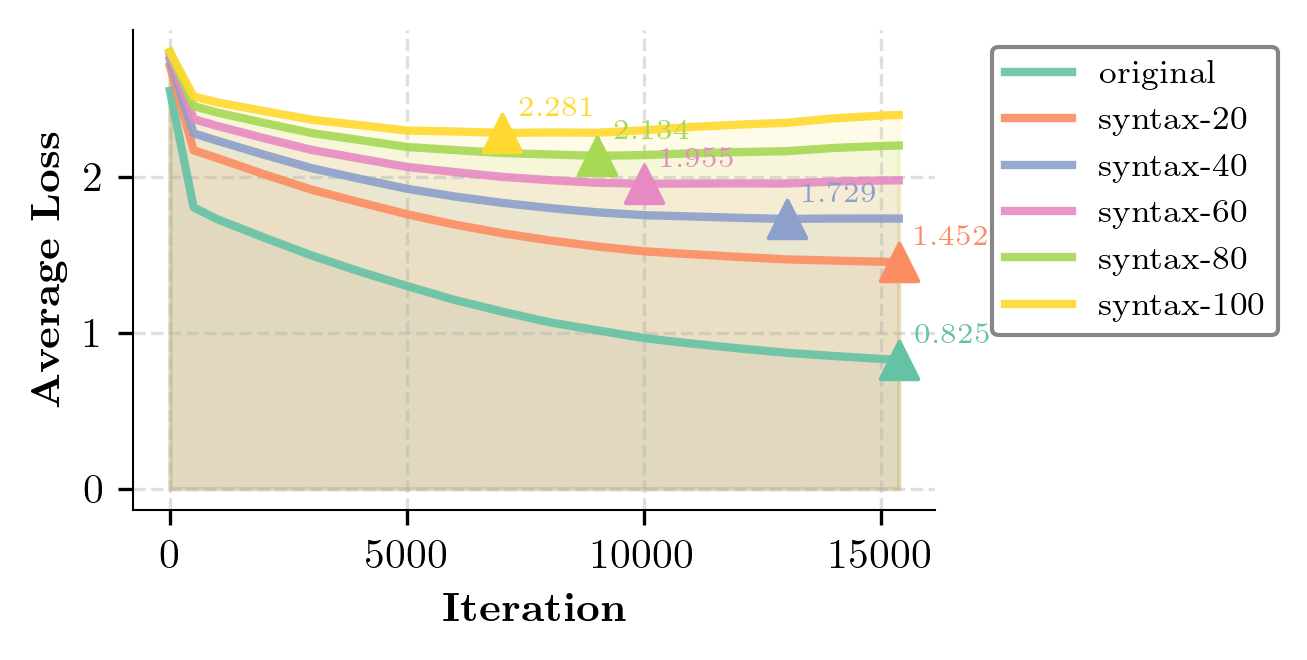

In [30]:
sequence_types = ["original", "rewrite@syntax-20", "rewrite@syntax-40", "rewrite@syntax-60", "rewrite@syntax-80", "rewrite@syntax-100"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-syntax.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted rewrite@lexicon-20: 18 data points
✓ Plotted rewrite@lexicon-40: 18 data points
✓ Plotted rewrite@lexicon-60: 18 data points
✓ Plotted rewrite@lexicon-80: 18 data points
✓ Plotted rewrite@lexicon-100: 18 data points


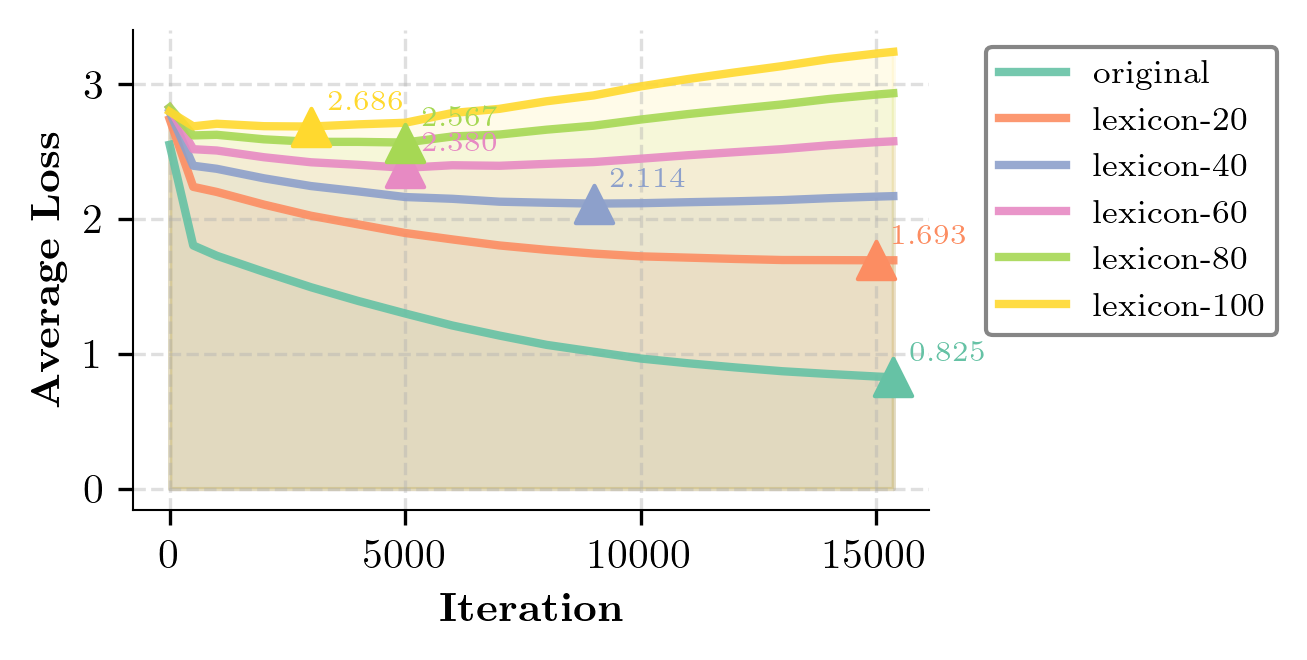

In [17]:
sequence_types = ["original", "rewrite@lexicon-20", "rewrite@lexicon-40", "rewrite@lexicon-60", "rewrite@lexicon-80", "rewrite@lexicon-100"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-lexicon-20.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted rewrite@semantic-20: 18 data points
✓ Plotted rewrite@semantic-40: 18 data points
✓ Plotted rewrite@semantic-60: 18 data points
✓ Plotted rewrite@semantic-80: 18 data points
✓ Plotted rewrite@semantic-100: 18 data points


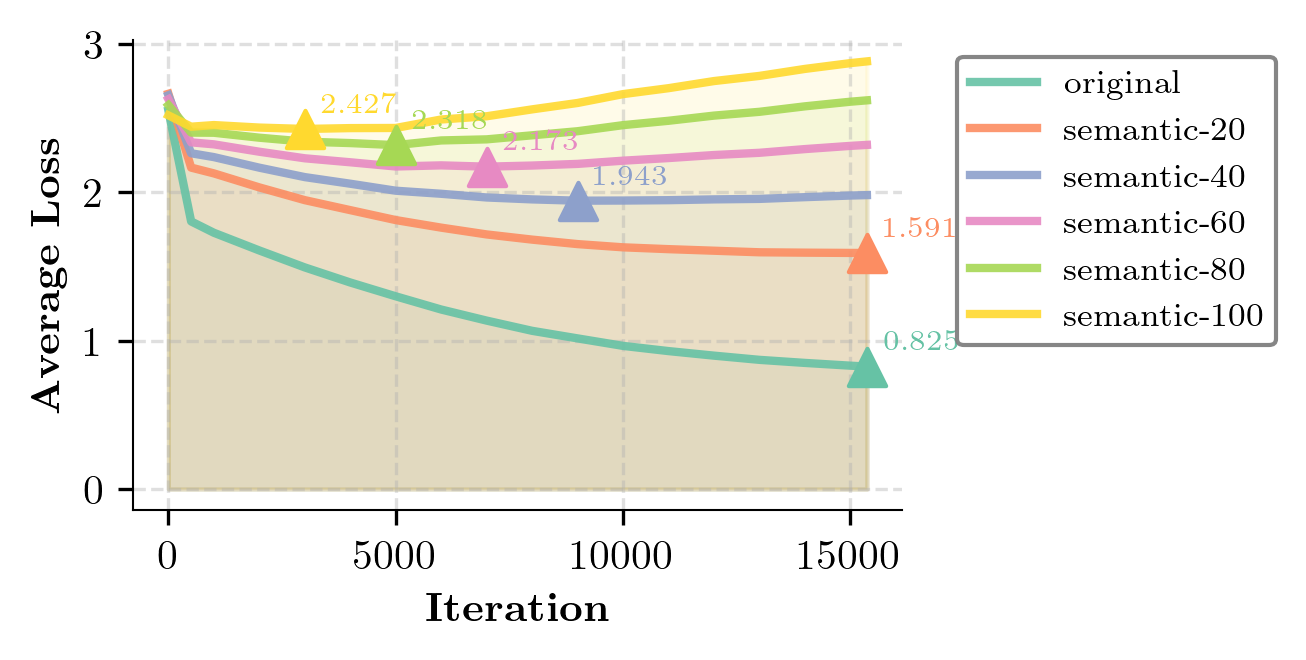

In [18]:
sequence_types = ["original", "rewrite@semantic-20", "rewrite@semantic-40", "rewrite@semantic-60", "rewrite@semantic-80", "rewrite@semantic-100"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-semantic-20.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

In [19]:
# sequence_types = ["original", "rewrite@wordtrans-20", "rewrite@wordtrans-40", "rewrite@wordtrans-60", "rewrite@wordtrans-80", "rewrite@wordtrans-100"]
# fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
# semantic

✓ Plotted original: 18 data points
✓ Plotted rewrite@translation-20: 18 data points
✓ Plotted rewrite@translation-40: 18 data points
✓ Plotted rewrite@translation-60: 18 data points
✓ Plotted rewrite@translation-80: 18 data points
✓ Plotted rewrite@translation-100: 18 data points


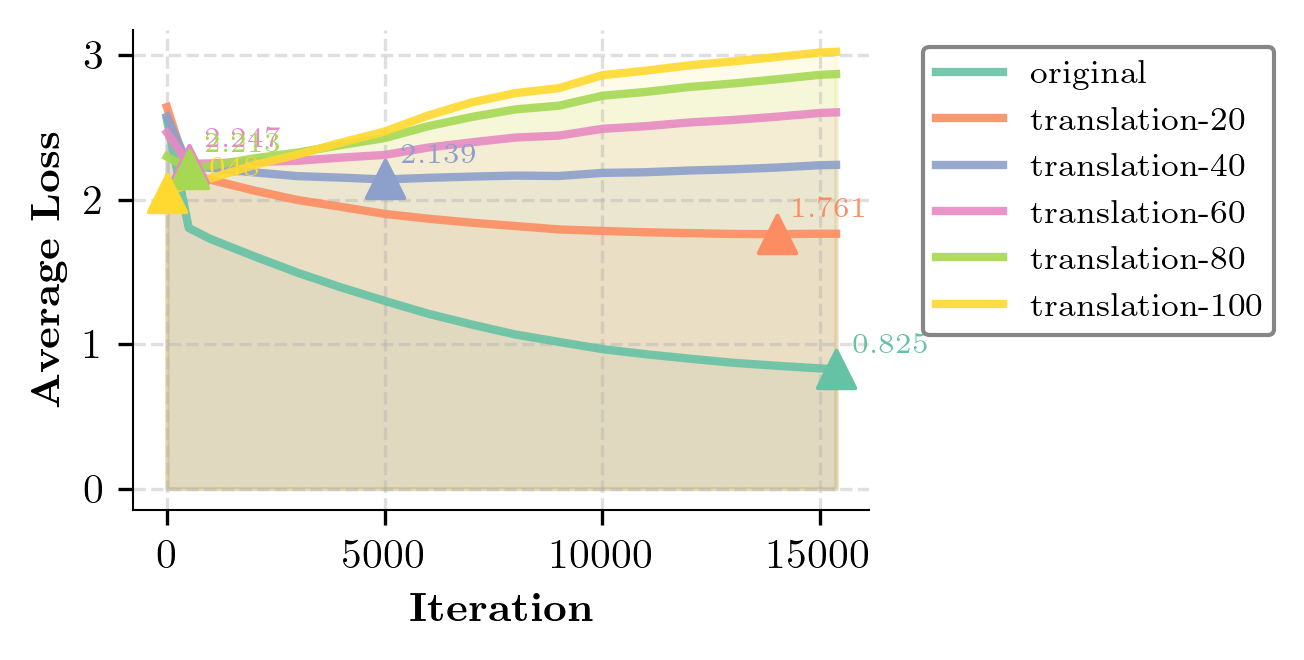

In [20]:
sequence_types = ["original", "rewrite@translation-20", "rewrite@translation-40", "rewrite@translation-60", "rewrite@translation-80", "rewrite@translation-100"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-trans-20.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted rewrite@syntax-20: 18 data points
✓ Plotted rewrite@lexicon-20: 18 data points
✓ Plotted rewrite@semantic-20: 18 data points
✓ Plotted rewrite@translation-20: 18 data points


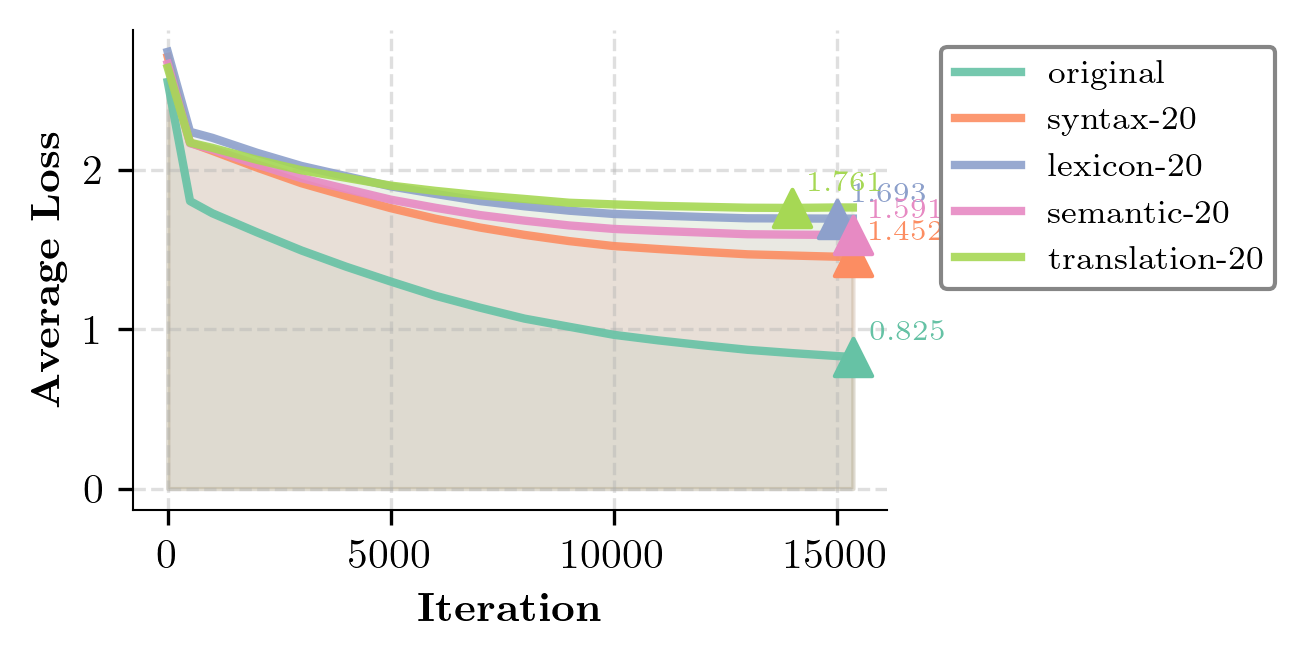

In [21]:
sequence_types = ["original", "rewrite@syntax-20", "rewrite@lexicon-20", "rewrite@semantic-20", "rewrite@translation-20"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-setence-perturb-20.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted rewrite@syntax-40: 18 data points
✓ Plotted rewrite@lexicon-40: 18 data points
✓ Plotted rewrite@semantic-40: 18 data points
✓ Plotted rewrite@translation-40: 18 data points


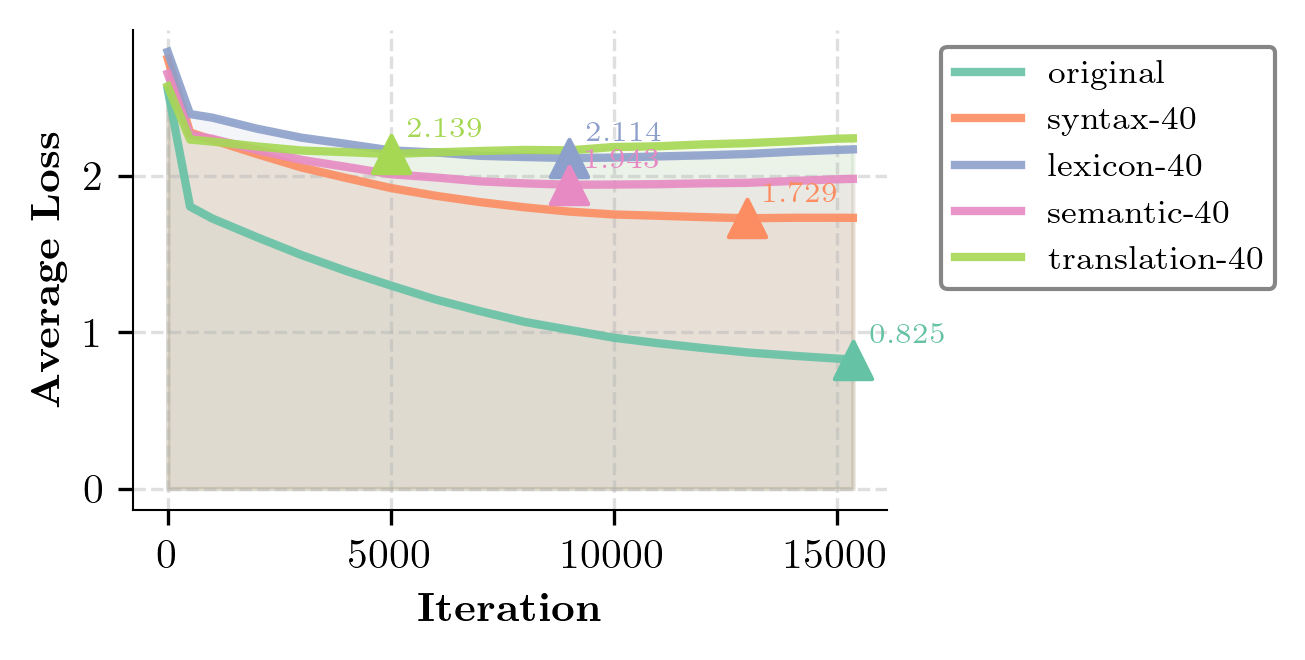

In [22]:
sequence_types = ["original", "rewrite@syntax-40", "rewrite@lexicon-40", "rewrite@semantic-40", "rewrite@translation-40"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-setence-perturb-40.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted rewrite@syntax-60: 18 data points
✓ Plotted rewrite@lexicon-60: 18 data points
✓ Plotted rewrite@semantic-60: 18 data points
✓ Plotted rewrite@translation-60: 18 data points


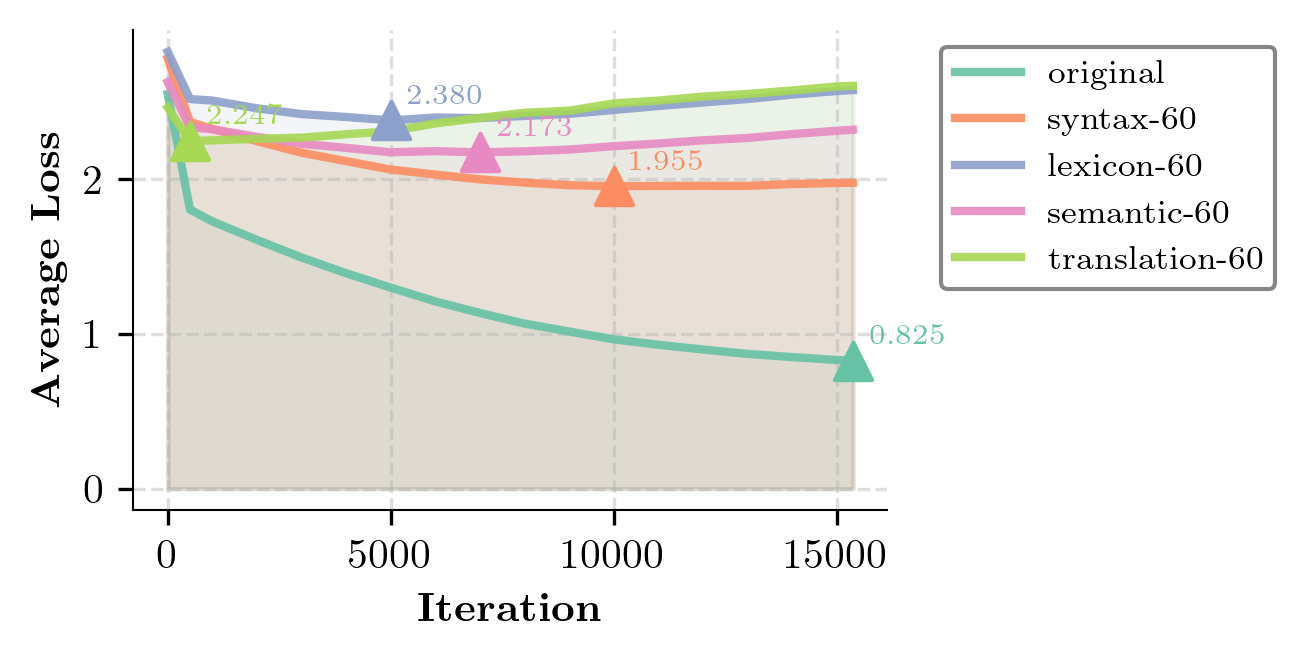

In [31]:
sequence_types = ["original", "rewrite@syntax-60", "rewrite@lexicon-60", "rewrite@semantic-60", "rewrite@translation-60"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-setence-perturb-60.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted rewrite@syntax-80: 18 data points
✓ Plotted rewrite@lexicon-80: 18 data points
✓ Plotted rewrite@semantic-80: 18 data points
✓ Plotted rewrite@translation-80: 18 data points


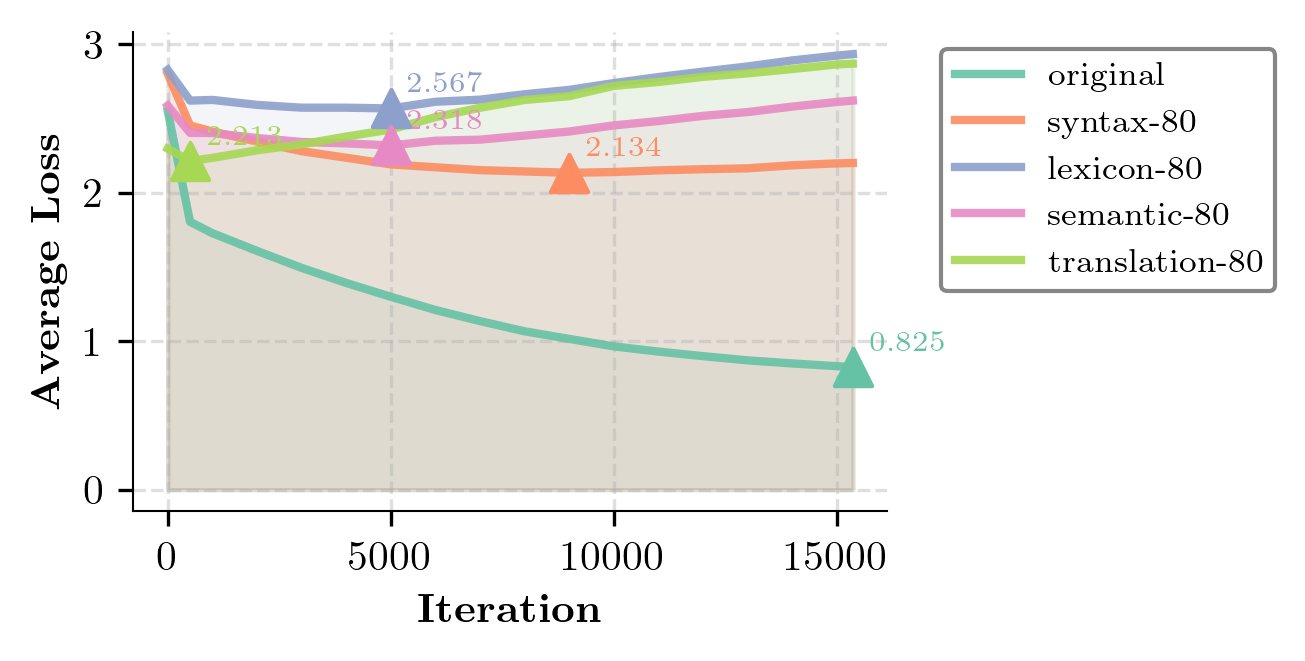

In [32]:
sequence_types = ["original", "rewrite@syntax-80", "rewrite@lexicon-80", "rewrite@semantic-80", "rewrite@translation-80"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-setence-perturb-80.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)

✓ Plotted original: 18 data points
✓ Plotted rewrite@syntax-100: 18 data points
✓ Plotted rewrite@lexicon-100: 18 data points
✓ Plotted rewrite@semantic-100: 18 data points
✓ Plotted rewrite@translation-100: 18 data points


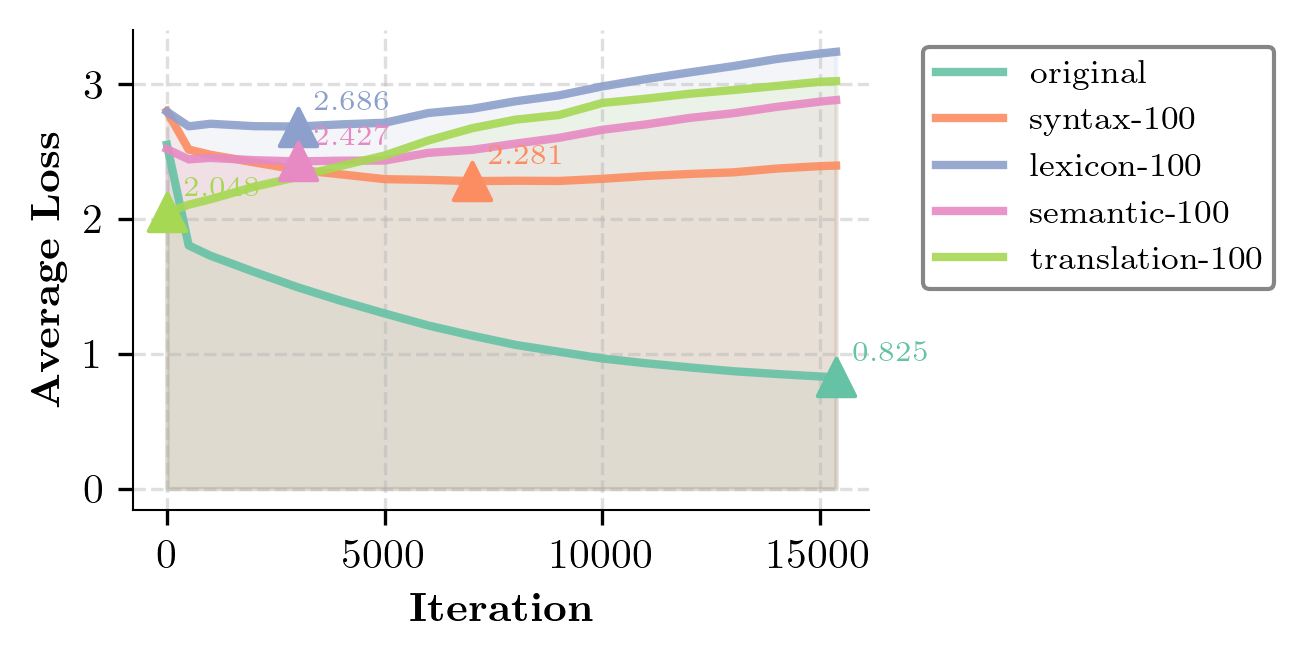

In [23]:
sequence_types = ["original", "rewrite@syntax-100", "rewrite@lexicon-100", "rewrite@semantic-100", "rewrite@translation-100"]
fig = plot_multiple_loss_curves_by_distortion(sequence_types, show_noise_rate=False)
fig.savefig('./loss_figures/ja-setence-perturb-100.pdf', format='pdf', bbox_inches='tight', dpi=300, transparent=True)